# Benchmarck of statistical forecast models

This document compares the performance (mean absolute error and speed) of different statistical models compatible with `skforecast.ForecasterStats`:

- SARIMAX from `statsmodels`
- ARIMA from `aeon`
- ARAR from `skforecast`
- ETS from `aeon`
  
It also includes an autoregressive model from `skforecast` using lightgbm as regressor for reference.

In [11]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast


In [12]:
# Libraries
# ==============================================================================
import pandas as pd
import skforecast
from skforecast.sarimax import Sarimax
from skforecast.stats import Arar
from skforecast.experimental import ForecasterStats
from skforecast.experimental import backtesting_stats
from skforecast.model_selection import TimeSeriesFold
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from aeon.forecasting.stats import ARIMA, ETS
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")


skforecast version: 0.18.0


In [13]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523
...,...
1989-09-01,687649.2852
1989-10-01,669889.1602
1989-11-01,601413.8867


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


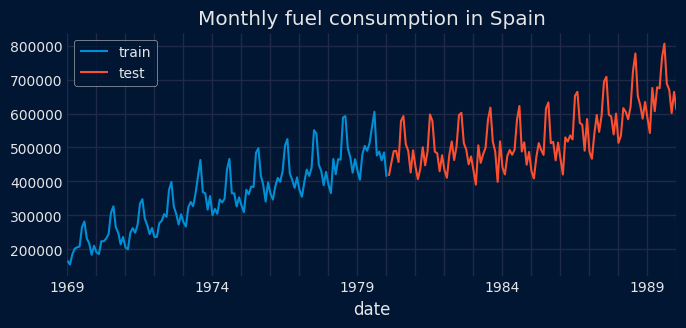

In [14]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [15]:
# Backtesting ForecasterStats with sarimax statsmodels
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
start = timeit.default_timer()
metric_sarimax, pred_sarimax = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_sarimax = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# Backtesting ForecasterStats with ARIMA aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=ARIMA(p=13, d=1, q=13, iterations=1000),
             )
start = timeit.default_timer()
metric_arima, pred_arima = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_arima = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# Backtesting ForecasterStats with ARAR skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 regressor=Arar(max_ar_depth=10, max_lag=10)
             )
start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# Backtesting ForecasterStats with ETS aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = False,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=ETS(seasonal_period=12),
             )
start = timeit.default_timer()
metric_ets, pred_ets = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )
stop = timeit.default_timer()
elapsed_time_ets = stop - start

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ If `ForecasterStats` uses a regressor different from `skforecast.stats.Sarimax`,     │
│ `cv.refit` must be `True` since predictions must start from the end of the training  │
│ set. Setting `cv.refit = True`.                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ /home/joaquin/Documents/GitHub/skforecast/skforecast/experimental/_validation.py:134 │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Sarimax",
            "ARIMA aeon",
            "ARAR skforecast",
            "ETS aeon",
        ],
        "MAE": [
            metric_sarimax.at[0, "mean_absolute_error"],
            metric_arima.at[0, "mean_absolute_error"],
            metric_arar.at[0, "mean_absolute_error"],
            metric_ets.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_sarimax,
            elapsed_time_arima,
            elapsed_time_arar,
            elapsed_time_ets,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,Sarimax,20528.190769,4.306324
1,ARAR skforecast,24211.988300,0.084046
2,ARIMA aeon,33398.995574,0.164004
3,ETS aeon,69275.286837,0.035707


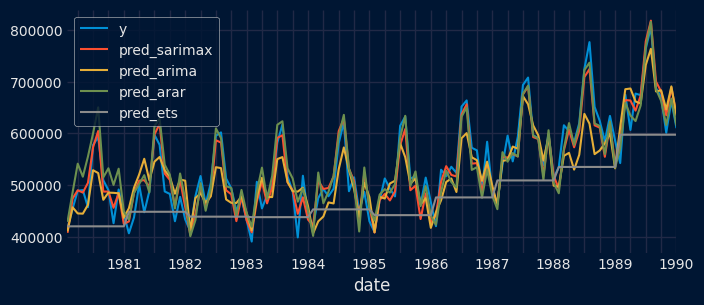

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_sarimax['pred'].plot(ax=ax, label='pred_sarimax')
pred_arima['pred'].plot(ax=ax, label='pred_arima')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
pred_ets['pred'].plot(ax=ax, label='pred_ets')
ax.legend();